In [20]:
import pandas as pd
import requests
import yfinance as yf
import investpy
from bs4 import BeautifulSoup
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime
from os import remove
from bson.json_util import dumps, loads

""" Entidad ACCION: Representa a cada titulo de empresa (una accion) que traemos desde la fuente de datos, la utilizamos antes de guardar los datos en la coleccion Mongo para darle un formato unificado al contenido. Tambien se puede usar para trabajar de forma individual con una accion en particular (En desarrollo). Los dos metodos que posee ademas del constructor actuan en conjunto para devolver la instancia como un diccionario"""

class Accion:
    def __init__(self, mercado, datosAccion):
        self.symbol = datosAccion[mercado.campo_nombre]
        self.max = datosAccion[mercado.campo_valorMaximo]
        self.min = datosAccion[mercado.campo_valorMinimo]
        self.ult = datosAccion[mercado.campo_UltimoPrecio]
        self.mov = datosAccion[mercado.campo_cambio]
        self.moneda = '' if not mercado.campo_moneda in datosAccion else datosAccion[mercado.campo_moneda]
        self.fecha = datosAccion[mercado.campo_fecha]
        self.hora = datosAccion[mercado.campo_hora]
        self.origen = mercado.__class__.__name__

    def keys(self):
        return ('symbol', 'max', 'min', 'ult', 'mov', 'moneda','fecha','hora','origen')

    def __getitem__(self, item):
        return getattr(self, item)

""" Entidad que representa la conexion con la base de datos MongoDB, revise dos parametros en su creacion: El nombre de la base de datos y el nombre la coleccion. De no existir se encarga de crearla. Posee el metodo borracColeccion para eliminar la coleccion. """
class Coleccion:
    def __init__(self, nombreBD, nombreColeccion):
        self.__abrirColeccion(nombreBD, nombreColeccion)

    def __abrirColeccion(self, nombreBD, nombreColeccion):
        client = MongoClient('localhost')
        bd = client[nombreBD]
        self.datos = bd[nombreColeccion]

    def borrarColeccion(self):
        self.datos.drop()

""" Entidad Mercado: Es la super clase encargada de definir los metodos para: guardar en la base de datos el contenido extraido de la fuente, visualizar los datos de la coleccion en pantalla, convertir los datos de la coleccion en dataframe, mostrar la cantidad de acciones de mayor perdida y ganancia y realizar distintos graficos analizando los datos de la coleccion. """
class Mercado:
    def __init__(self):
        self.bd = Coleccion('Mercados', self.__class__.__name__)
        self.coleccion = self.bd.datos
        self.bd.borrarColeccion()
        self.obtenerDatos()
        
    def _guardarEnBD(self, dataFrame):
        array_objetos = []
        dataFrame = dataFrame.to_dict('records')
        for fila in dataFrame:
            fila_accion = dict(Accion(self, fila))
            array_objetos.append(fila_accion)
        self.bd.borrarColeccion()
        self.coleccion.insert_many(array_objetos)
        
    def imprimirColeccion(self):
        for documento in self.coleccion.find({}):
            print(documento)
            
    def imprimirDF(self):
        print (self.__documentADF(self.coleccion.find({})))

    def __documentADF(self, listColeccion):
        df = pd.DataFrame(list(listColeccion))
        return df if not '_id' in df.columns else df.drop(['_id'], axis=1)
        
    def imprimirMayorGanancia(self,cantidad):
        """ Imprime en pantalla la cantidad de acciones requeridas que 
        tuvieron mayor ganancia """
        df = self.buscarPorNombre().sort_values(by='mov', ascending = False)
        print("Acciones de mayor ganancia\n",df.head(cantidad))

    def imprimirMayorPerdida(self,cantidad):
        """ Imprime en pantalla la cantidad de acciones requeridas que 
        tuvieron mayor perdida """
        df = self.buscarPorNombre().sort_values(by='mov', ascending = False)
        print("Acciones de mayor pérdida\n",df.tail(cantidad))
        
    
    #vamos a graficar los valores positivos de un color y los negativos de otro color
    def graficarGananciaPerdida(self,titulo,nombre):
        df = self.buscarPorNombre()
        dfPositivos = df[df['mov']>=0].rename({'mov': 'Ganancia'}, axis=1)#filtramos las acciones con ganancia
        dfNegativos = df[df['mov']<0 ].rename({'mov': 'Pérdida'}, axis=1)#filtramos las acciones con pérdida
        df = pd.concat([dfPositivos,dfNegativos]).sort_values(by='symbol')   #unimos las tablas ordenadas por el nombre
        #armamos el gráfico 
        plt.style.use('seaborn') #estilo grafico
        df[['symbol', 'Ganancia', 'Pérdida']].plot('symbol', kind="bar", width=1, color=["#04D8B2","#EF4026"],figsize=(12,10)) #parámetros: columnas, tipo de gráfico, ancho de las barras, colores de las barras
        plt.title(titulo) #título del grafico
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') #guardamos el gráfico, 'tight' para guardarlo completo [parámetro: nombre]
        plt.tight_layout();plt.show() #mostramos el gráfico de manera completa
    
    def graficarAcciones(self, symbol):
        df = self.buscarPorNombre([symbol])
        df[['fecha','ult']].plot('fecha', kind="line", title= f"{symbol}", figsize=(8,5))
        plt.xticks(rotation=45)
        plt.xlabel('Últimos 30 días') #título del eje de las x
        plt.tight_layout();plt.show()       
        
    def buscarPorNombre(self, nombreAccion = False):
        if not nombreAccion:
            documents = self.coleccion.find({})
        else:
            documents = self.coleccion.find({'symbol': {"$in": nombreAccion}}) 
        return self.__documentADF(documents)
        
    def accion(self, symbol):
        # Converting to the JSON
        cursor = self.coleccion.find_one({'symbol': symbol})
        return cursor
        """         json_data = dumps(cursor, indent = 2) 
        return loads(json_data) """

        
""" Entidad BolsaDeMadrid: hereda de la superclase Mercado y define su propio metodo para obtener los datos de la fuente. Define atributos de clase que representan los nombres de las columnas con la informacion obtenida, estos datos se usan para formatear el contenido que se guarda en la base de datos """
class BolsaDeMadrid(Mercado):
    campo_nombre = 'Nombre'
    campo_valorMaximo = 'Máx'
    campo_valorMinimo = 'Mín'
    campo_UltimoPrecio = 'Últ'
    campo_cambio = '% Dif'
    campo_moneda = 'Moneda'
    campo_fecha = 'Fecha'
    campo_hora = 'Hora'
    
    moneda = 'Euro'

    def __init__(self):
        super().__init__()

    def obtenerDatos(self):
        #Hacemos la consulta a la pagina y guardamos el contenido en una variable soup
        url_page = 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'
        page = requests.get(url_page).text 
        soup = BeautifulSoup(page, "lxml")

        #Buscamos la tabla de donde obtener los datos
        tabla = soup.find('table', attrs={'id': 'ctl00_Contenido_tblAcciones'})

        #creamos una lista vacia que llenaremos con los datos de las tablas
        columnas = []
        
        #buscamos los encabezados de la tabla y los agregamos a la lista columnos (deberia ubicarse en la posicion 0)
        headers = []
        for th in tabla.find_all('th'):
            headers.append(th.text.replace('.',''))
        """         headers.append('Fecha')
        headers.append('Hora')
        headers.append('Moneda') """
        columnas.append(headers)

        for tr in tabla.find_all('tr'):
            fila = []
            for td in tr.find_all('td'):
                fila.append(td.text)
            if len(fila) > 0:
                """ fila.append(fechaActual)
                fila.append(horaActual)
                fila.append(self.moneda) """
                columnas.append(fila)
                
        #creamos el dataframe usando la lista columnas,pasamos el contenido (de la posicion 1 en adelante), y lo encabezados en (posicion 0)
        df = pd.DataFrame(columnas[1:], columns=columnas[0])

        #Asigna valores de tipo de moneda, fecha y hora actuales.
        df=df.assign(Moneda=self.moneda,Fecha=datetime.now().strftime('%d/%m/%Y'),Hora=datetime.now().strftime('%H:%M:%S'))

        #Convertirmos a float
        df = self.__convertirAFloat(df)

        #Guardamos los datos en la base de datos
        self._guardarEnBD(df)
        
    def __convertirAFloat(self, df):
        df["% Dif"] = df["% Dif"].str.replace(",", ".").astype(float)
        df["Máx"] = df["Máx"].str.replace(",", ".").astype(float)
        df["Mín"] = df["Mín"].str.replace(",", ".").astype(float)
        df["Últ"] = df["Últ"].str.replace(",", ".").astype(float)
        return df

""" Entidad Invest: Representa los datos de mercado usando la libreria investPy que extrae los datos de invest.com. Hereda de la clase Mercado, y tiene atributos que representan sus columnas """
class Investing(Mercado):
    
    campo_nombre = 'symbol'
    campo_valorMaximo = 'high'
    campo_valorMinimo = 'low'
    campo_UltimoPrecio = 'last'
    campo_cambio = 'GP'
    campo_moneda = 'Moneda'
    campo_fecha = 'Fecha'
    campo_hora = 'Hora'

    moneda = 'Euro'
    
    def __init__(self):
        super().__init__()

    def obtenerDatos(self, cant_result = 35):
        #Lee los datos desde la fuente
        df = investpy.stocks.get_stocks_overview(country='spain', as_json = False , n_results = cant_result
        )  
        #cambiar la columna de movimientos a numérica
        df = self.__porcentajeCambio(df)
        df['GP'] = df['GP'].apply(pd.to_numeric)

        #Asigna valores de tipo de moneda, fecha y hora actuales.
        df=df.assign(Moneda=self.moneda,Fecha=datetime.now().strftime('%d/%m/%Y'),Hora=datetime.now().strftime('%H:%M:%S'))

        #Guarda los datos en la base de datos
        self._guardarEnBD(df)
    
    def __porcentajeCambio(self, df):
        return df.join(df['change_percentage'].str.partition('%')[[0, 1]]).rename({0: 'GP', 1: '%'}, axis=1)

""" Entidad YahooFinance: Hereda de la clase mercado, posee sus atributos de clase para los nombre de las columnas. Utiliza la libreria yfinance para extraer los datos de bolsa desde yahoofinance.com """
class YahooFinance(Mercado):
    campo_nombre = 'Ticker'
    campo_valorMaximo = 'High'
    campo_valorMinimo = 'Low'
    campo_UltimoPrecio = 'Close'
    campo_cambio = 'Dif'
    campo_moneda = 'Moneda'
    campo_fecha = 'Date'
    campo_hora = 'Hora'
    
    moneda = 'Euro'
    
    def __init__(self, acciones, periodo = '1d'):
        """ Recibimos el atributo acciones, ya que yahoo finance necesita saber que acciones buscar """
        self.acciones = acciones
        self.periodo = periodo
        super().__init__()
        

    def obtenerDatos(self, acciones = False, periodo = False):
        df_list = list()
        if acciones:
            self.acciones = acciones
        if periodo:
            self.periodo = periodo
        for accion in self.acciones:
            if not " " in accion and ".MC" in accion:
                data = yf.download(accion, group_by='ticker', period= self.periodo)
                if not data.empty:
                    data['Ticker'] = accion
                    data['Dif'] = self.__calcularDiferencia(data['Open'], data['Close'])
                    df_list.append(data)
                    
        if len(df_list) > 0:
            df = self.__aplanarColumna(df_list)

            #agregamos moneda, hora
            df=df.assign(Moneda=self.moneda,Hora=datetime.now().strftime('%H:%M:%S'))

            #Guardamos en la base de datos
            self._guardarEnBD(df)
    
    def __calcularDiferencia(self, A, B):
        return (B*100)/A-100

    def __aplanarColumna(self, df):
            df = pd.concat(df)
            df.to_csv('yahoo_finance.csv')
            df = pd.read_csv('yahoo_finance.csv')
            remove('yahoo_finance.csv')
            return df


In [21]:
""" Entidad Cotizaciones: Unifica las cotizaciones de los 3 mercados y grafica la comparación de la última cotización de 
los mismos """
class Cotizaciones():

    def __init__(self, acciones, mercados):
        self.acciones = acciones
        self.mercados = mercados
       
    def juntarDBS(self):
        df = pd.DataFrame()
        for mercado in self.mercados:
            df = pd.concat([df, mercado.buscarPorNombre(self.acciones)], axis=0).sort_values(by='symbol') 
        print(df)
        return df
    
    def graficarComparacion(self,titulo,nombre):
        df = self.juntarDBS()
        comparar = df.groupby(['symbol', 'origen']).mean()["ult"] #agrupamos según el mercado y mostramos la última cotización
        comparar.plot(kind="bar",width=0.9, color=["#06C2A6","#FF7960","#DBB40C"], figsize=(8,8)) #genera el gráfico de barras
        plt.style.use('seaborn') #estilo de gráfico    
        plt.title(titulo) #título del grafico 
        plt.xlabel('Acciones') #título del eje de las x
        plt.savefig(nombre, bbox_inches='tight') #guardamos el gráfico, 'tight' para guardarlo completo [parámetro: nombre]
        plt.tight_layout();plt.show() #mostramos el gráfico de manera completa

ACA EMPIEZA ARCHIVO MAIN

In [22]:
""" Objetivo 1: Leer los datos, guardarlos en la base y luego leerlos y
mostrarlos en pantalla """ 

#Nombramos las acciones que queremos buscar
listaAcciones =[
    'BBVA', "BBVA.MC",
    'ELE', "ELE.MC", 'ENDESA',
    'GRLS', "GRF.MC", 'GRIFOLS CL.A',
    'INDRA A', 'IDR',"IDR.MC",
    "REP.MC", 'REP','REPSOL'
    ]

accionesBolsaMadrid = BolsaDeMadrid()
accionesInvesting = Investing()
accionesYFinance = YahooFinance(listaAcciones)

mercados = [accionesBolsaMadrid, accionesInvesting, accionesYFinance]

for mercado in mercados:
    mercado.imprimirDF()
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
          symbol       max       min       ult   mov moneda       fecha  \
0        ACCIONA  159.6000  156.3000  157.7000  0.45   Euro  08/11/2021   
1       ACERINOX   11.4000   11.1300   11.3350  1.02   Euro  08/11/2021   
2            ACS   23.3700   22.9500   23.1200 -0.82   Euro  08/11/2021   
3           AENA  152.0000  149.2000  149.7500 -0.99   Euro  08/11/2021   
4       ALMIRALL   12.5400   12.3000   12.4700  0.65   Euro  08/11/2021   
5        AMADEUS   63.0600   61.5400   62.3800  0.71   Euro  08/11/2021   
6    ARCELORMIT.   29.0200   27.9750   28.8550  3.24   Euro  08/11/2021   
7    B.SANTANDER    3.3000    3.2380    3.2380 -1.40   

Acciones de mayor ganancia
           symbol    max     min     ult   mov moneda       fecha      hora  \
31  SIEMENS GAME  20.64  19.150  20.460  8.92   Euro  08/11/2021  16:08:52   
6    ARCELORMIT.  29.02  27.975  28.855  3.24   Euro  08/11/2021  16:08:52   

           origen  
31  BolsaDeMadrid  
6   BolsaDeMadrid  
Acciones de mayor pérdida
           symbol    max     min     ult   mov moneda       fecha      hora  \
21       INDITEX  32.10  31.270  31.470 -2.48   Euro  08/11/2021  16:08:52   
25  MELIA HOTELS   6.92   6.618   6.728 -2.58   Euro  08/11/2021  16:08:52   

           origen  
21  BolsaDeMadrid  
25  BolsaDeMadrid  
Acciones de mayor ganancia
    symbol     max     min     ult   mov moneda       fecha      hora  \
10  SGREN  20.645  19.290  20.470  8.88   Euro  08/11/2021  16:08:53   
26    OHL   0.798   0.735   0.777  7.77   Euro  08/11/2021  16:08:53   

       origen  
10  Investing  
26  Investing  
Acciones de mayor pérdida
    symbol    max     min     ult   

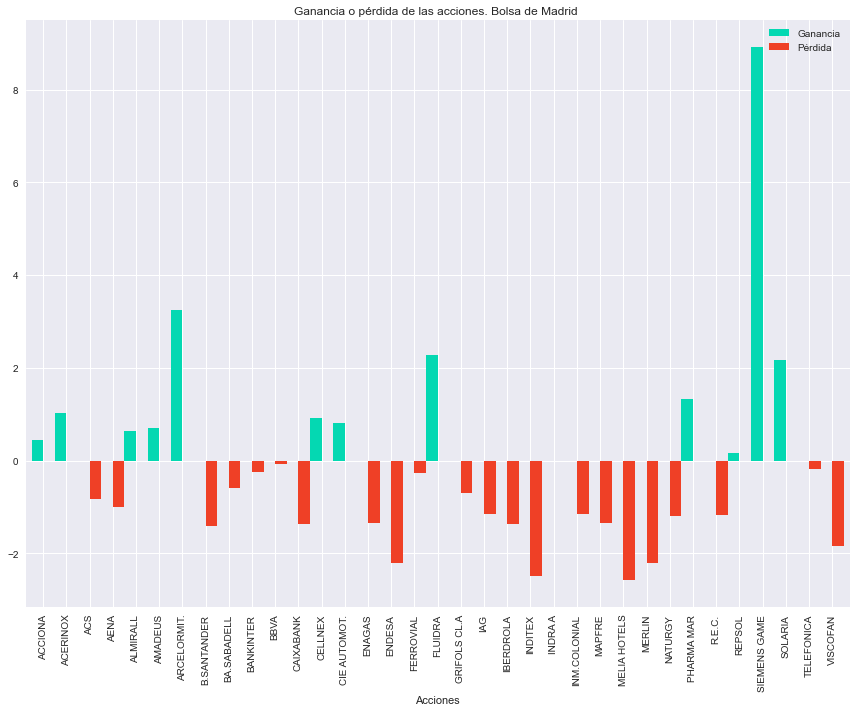

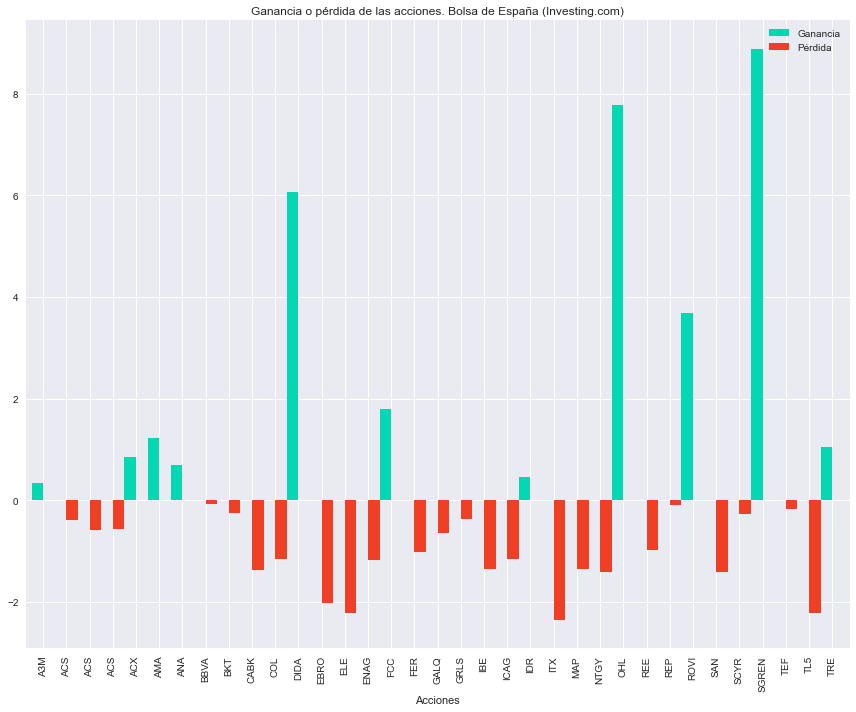

In [23]:
""" Objetivo 2: Identificar las 2 acciones de mayor ganancia y de mayor perdida """


for mercado in mercados:
    if mercado != accionesYFinance:
        mercado.imprimirMayorGanancia(2)
        mercado.imprimirMayorPerdida(2)

accionesBolsaMadrid.graficarGananciaPerdida('Ganancia o pérdida de las acciones. Bolsa de Madrid ', 'ganPerBolsaMadrid.png')
accionesInvesting.graficarGananciaPerdida('Ganancia o pérdida de las acciones. Bolsa de España (Investing.com)', 'ganPerInvesting.png')


         symbol     max        min        ult       mov moneda       fecha  \
0          BBVA   6.089   5.995000   6.021000 -0.080000   Euro  08/11/2021   
0          BBVA   6.089   5.995000   6.021000 -0.080000   Euro  08/11/2021   
0       BBVA.MC   6.089   5.995000   6.021000  0.249748   Euro  2021-11-08   
4           ELE  20.080  19.557000  19.575000 -2.220000   Euro  08/11/2021   
1        ELE.MC  20.090  19.555000  19.559999 -2.297707   Euro  2021-11-08   
1        ENDESA  20.090  19.555000  19.560000 -2.200000   Euro  08/11/2021   
2        GRF.MC  18.730  18.334999  18.370001 -0.836701   Euro  2021-11-08   
2  GRIFOLS CL.A  18.730  18.335000  18.370000 -0.700000   Euro  08/11/2021   
1          GRLS  18.730  18.328000  18.413000 -0.360000   Euro  08/11/2021   
3           IDR  10.845  10.685000  10.810000  0.460000   Euro  08/11/2021   
3        IDR.MC  10.850  10.690000  10.780000  0.559696   Euro  2021-11-08   
3       INDRA A  10.850  10.690000  10.780000  0.000000   Euro  

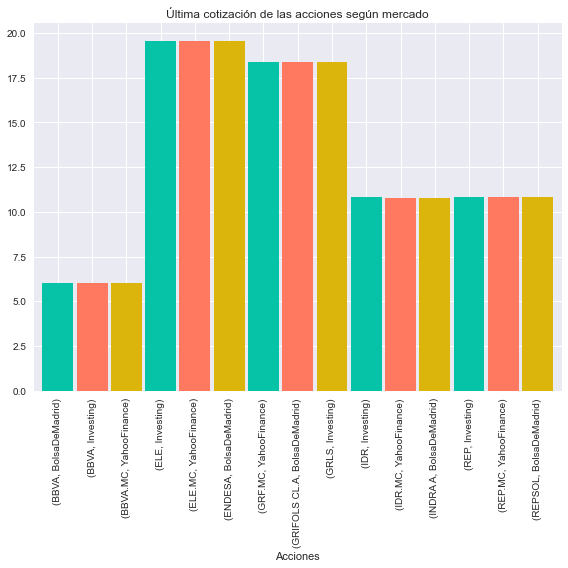

In [24]:

""" Objetivo 3: Comparativa de precios de cotización entre los orígenes de datos. """
comparacion = Cotizaciones(listaAcciones, mercados)
comparacion.graficarComparacion('Última cotización de las acciones según mercado', 'comparacionMercados.png')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


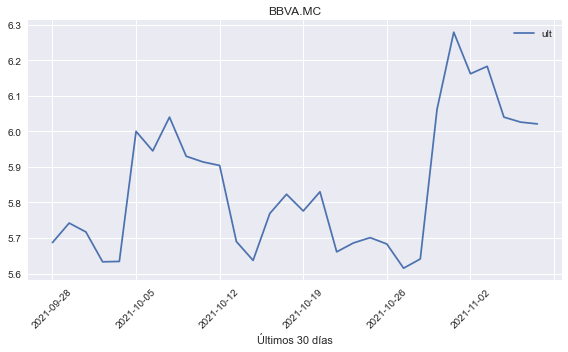

In [25]:

""" 2. Datos historicos yahoo finance """
accionesYFinance.obtenerDatos(periodo='30d')
accionesYFinance.graficarAcciones('BBVA.MC')

